In [ ]:
# pip install pandas langchain_community langchain_core langchain-tavily seaborn python-dotenv openai sentence-transformers chromadb scikit-learn

In [2]:
import pandas as pd # type: ignore
import numpy as np
import json
import re
from typing import List, Dict, Any, Tuple, Literal, TypedDict
from sentence_transformers import SentenceTransformer # type: ignore
from openai import OpenAI # type: ignore
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from dotenv import load_dotenv
import os

In [3]:
load_dotenv()

openai_api_key = os.getenv("OPEN_AI_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [6]:
df_qa = pd.read_csv("medical_qna_dataset.csv")
df_qa = df_qa.sample(500, random_state=0).reset_index(drop=True)
df_qa.head()

,qtype,Question,Answer
0,frequency,How many people are affected by X-linked chond...,The prevalence of X-linked chondrodysplasia pu...
1,treatment,What are the treatments for Kawasaki disease ?,These resources address the diagnosis or manag...
2,genetic changes,What are the genetic changes related to Ellis-...,Ellis-van Creveld syndrome can be caused by mu...
3,symptoms,What are the symptoms of Renal dysplasia-limb ...,What are the signs and symptoms of Renal dyspl...
4,information,What is (are) Fraser syndrome ?,Fraser syndrome is a rare disorder that affect...


In [7]:
df_qa['combined_text'] = (
    "Question: " + df_qa['Question'].astype(str) + '. ' + 
    "Answer: " + df_qa['Answer'].astype(str) + '. ' + 
    "Type: " + df_qa['qtype'].astype(str) + '. '
)
df_qa.head()

,qtype,Question,Answer,combined_text
0,frequency,How many people are affected by X-linked chond...,The prevalence of X-linked chondrodysplasia pu...,Question: How many people are affected by X-li...
1,treatment,What are the treatments for Kawasaki disease ?,These resources address the diagnosis or manag...,Question: What are the treatments for Kawasaki...
2,genetic changes,What are the genetic changes related to Ellis-...,Ellis-van Creveld syndrome can be caused by mu...,Question: What are the genetic changes related...
3,symptoms,What are the symptoms of Renal dysplasia-limb ...,What are the signs and symptoms of Renal dyspl...,Question: What are the symptoms of Renal dyspl...
4,information,What is (are) Fraser syndrome ?,Fraser syndrome is a rare disorder that affect...,Question: What is (are) Fraser syndrome ?. Ans...


In [8]:
df_md = pd.read_csv('medical_device_manuals_dataset.csv')
df_md = df_md.sample(500, random_state=0).reset_index(drop=True)
df_md.head()

,Device_Name,Model_Number,Manufacturer,Manual_Version,Publication_Date,Device_Class,Regulatory_Approval_ID,Patient_Population,Indications_for_Use,Contraindications,Sterilization_Method,Number_of_Warnings,Number_of_Cautions,Device_Lifetime_Years,Device_Weight_kg,Max_Operating_Temperature_C
0,Electrosurgical Unit,Model 1606,Zimmer Biomet,2023-04-Z,2018-04-28,Class IIb,MDR-847127,All,Used for thermal therapy guidance in oncology ...,Contraindicated in presence of radio frequenci...,Hydrogen Peroxide Plasma,10,15,15.0,6.71,27.0
1,Dialysis Machine,X-6538,3M Healthcare,v2.8,2018-04-03,Class I,MDR-416480,Adult (>65),Used for post-operative chemotherapy managemen...,NaN,Gamma Irradiation,8,11,11.0,NaN,17.0
2,Ventilator,SON230,Sonova,Version 13,2022-02-24,Class III,BLA670706,Adult (>65),Indicated for real-time temperature assessment...,Do not use during general anesthesia administr...,Pre-Sterilized,18,28,11.0,149.42,25.0
3,Dialysis Machine,Max787,Boston Scientific,v4.7,2016-05-08,Class II,BLA131698,Neonatal,Intended for sterilization guidance during min...,"Not recommended during pregnancy, lactation, o...",NaN,10,15,15.0,20.96,20.0
4,Electrosurgical Unit,Plus691,Abbott,2020-03-Q,2015-01-30,Class III,H127393,Pediatric,Intended for life support evaluation in rehabi...,Contraindicated in patients with severe diabet...,Single-Use Sterile,13,17,8.0,7.75,31.0


In [9]:
df_md['combined_text'] = (
    "Device Name: " + df_md['Device_Name'].astype(str) + ". " +
    "Model: " + df_md['Model_Number'].astype(str) + ". " +
    "Manufacturer: " + df_md['Manufacturer'].astype(str) + ". " +
    "Indications: " + df_md['Indications_for_Use'].astype(str) + ". " +
    "Contraindications: " + df_md['Contraindications'].fillna('None').astype(str)
)
df_md.head()

,Device_Name,Model_Number,Manufacturer,Manual_Version,Publication_Date,Device_Class,Regulatory_Approval_ID,Patient_Population,Indications_for_Use,Contraindications,Sterilization_Method,Number_of_Warnings,Number_of_Cautions,Device_Lifetime_Years,Device_Weight_kg,Max_Operating_Temperature_C,combined_text
0,Electrosurgical Unit,Model 1606,Zimmer Biomet,2023-04-Z,2018-04-28,Class IIb,MDR-847127,All,Used for thermal therapy guidance in oncology ...,Contraindicated in presence of radio frequenci...,Hydrogen Peroxide Plasma,10,15,15.0,6.71,27.0,Device Name: Electrosurgical Unit. Model: Mode...
1,Dialysis Machine,X-6538,3M Healthcare,v2.8,2018-04-03,Class I,MDR-416480,Adult (>65),Used for post-operative chemotherapy managemen...,NaN,Gamma Irradiation,8,11,11.0,NaN,17.0,Device Name: Dialysis Machine. Model: X-6538. ...
2,Ventilator,SON230,Sonova,Version 13,2022-02-24,Class III,BLA670706,Adult (>65),Indicated for real-time temperature assessment...,Do not use during general anesthesia administr...,Pre-Sterilized,18,28,11.0,149.42,25.0,Device Name: Ventilator. Model: SON230. Manufa...
3,Dialysis Machine,Max787,Boston Scientific,v4.7,2016-05-08,Class II,BLA131698,Neonatal,Intended for sterilization guidance during min...,"Not recommended during pregnancy, lactation, o...",NaN,10,15,15.0,20.96,20.0,Device Name: Dialysis Machine. Model: Max787. ...
4,Electrosurgical Unit,Plus691,Abbott,2020-03-Q,2015-01-30,Class III,H127393,Pediatric,Intended for life support evaluation in rehabi...,Contraindicated in patients with severe diabet...,Single-Use Sterile,13,17,8.0,7.75,31.0,Device Name: Electrosurgical Unit. Model: Plus...


# SETUP CHROMA DB

In [10]:
import chromadb

client = chromadb.PersistentClient(path='./chroma_db')

In [11]:
collection1 = client.get_or_create_collection(name='medical_qna')

In [12]:
collection1.add(
    documents=df_qa['combined_text'].tolist(),
    metadatas = df_qa.to_dict(orient='records'),
    ids=df_qa.index.astype(str).tolist()
)

/Users/matthewbeattie/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:21<00:00, 3.81MiB/s]


In [13]:
collection2 = client.get_or_create_collection(name='medical_device_manual')

In [14]:
collection2.add(
    documents=df_md['combined_text'].tolist(),
    metadatas=df_md.to_dict(orient="records"),
    ids=df_md.index.astype(str).tolist(),
)

In [15]:
query = "what are the devices relevant to surgery"

results = collection2.query(query_texts=[query], n_results=3)
print(results)

{'ids': [['403', '142', '82']], 'embeddings': None, 'documents': [['Device Name: Orthopedic Implant. Model: Model 4592. Manufacturer: Intuitive Surgical. Indications: Used for post-operative thermal therapy management in hospital recovery units.. Contraindications: Avoid use if patient has coagulopathy or is receiving iodine compounds.', 'Device Name: Surgical Robot. Model: BIO146. Manufacturer: BioMérieux. Indications: Used for therapeutic drug delivery in neonatal patients requiring wound debridement.. Contraindications: Avoid use in patients with mesh implants or mesh implants. Not suitable for infectious disease isolation.', 'Device Name: Anesthesia Machine. Model: C-1766. Manufacturer: Edwards Lifesciences. Indications: Used for intraoperative sterilization monitoring during complex oncological surgeries.. Contraindications: Avoid use in patients with active hepatic dysfunction or compromised respiratory function.']], 'uris': None, 'included': ['metadatas', 'documents', 'distances

# SETUP WEB SEARCH

In [16]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(topic="general", max_results=3)

query = 'What is speciality of dunkirk'

result = tavily_search.invoke({"query": query})

result['results'][1]['content']

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


"## Dunkirk. Just 10 minutes from Bray-Dunes lies the great and surprising city of Dunkirk! Located on the north coast of France, Dunkirk is a city by the sea, rich in history, culture and tourist attractions. IMMERSE YOURSELF IN THE HISTORY OF DUNKIRK. Dunkirk has been the scene of a number of significant historical events, including the famous evacuation of Allied troops during the Second World War. * Dunkirk has a rich historical heritage. You can explore the belfries: the belfries of Gravelines, Saint Eloi and Dunkirk town hall are all UNESCO World Heritage Sites. * Other Dunkirk museums worth visiting include the Dunkerque 1940 - Opération Dynamo museum, the Musée de la mer, the Jean Bart construction site, the Palais de l'Univers et des Sciences and the LAAC (Lieu d'art et d'Action contemporaine). STROLL THROUGH DUNKIRK CITY CENTRE. Although we have already touched on this subject a little earlier, Dunkirk is above all a city marked by history. The Fort des Dunes is just a few ki

# SETUP OPENAI API

In [17]:
from langchain_core.tools import tool

from openai import OpenAI

def get_llm_response(prompt: str) -> str:
    """Function to get response from LLM"""
    from openai import OpenAI
    client_llm = OpenAI(api_key=openai_api_key)
    response = client_llm.chat.completions.create(
        model="gpt-5-nano",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

prompt = "What is speciality of dunkirk"
response = get_llm_response(prompt)

In [18]:
print(response)

Do you mean Dunkirk the city in France, the WWII evacuation, or the Christopher Nolan film “Dunkirk”? Here are quick highlights for each:

- City (Dunkerque, France): A major port on the North Sea near Belgium; known for its maritime history, beaches, and localCarnaval culture.

- WWII event: The Dunkirk evacuation (Operation Dynamo) in 1940, when hundreds of thousands of Allied troops were evacuated from the beaches of Dunkirk; it’s often cited as a symbol of resilience “the Dunkirk Spirit.”

- Film: The 2017 movie Dunkirk, notable for its immersive, three intersecting timelines (land, sea, air), practical effects, and a rousing score.

If you tell me which one you mean, I can dive into more detail.


# BUILD THE PIPELINE

In [24]:
from langgraph.graph import StateGraph, MessagesState, START, END

def retrieve_context_q_n_a(state):
    """Retrieve top documents from ChromaDB Collection 1 (Medical Q&A Data) based on query."""
    print("---RETRIEVING CONTEXT---")
    query = state["query"] 
    results = collection1.query(query_texts=[query], n_results=3)
    context = "\n".join(results["documents"][0])
    state["context"] = context
    state["source"] = "Medical Q&A Collection"
    print(context)
    
    return state

def retrieve_context_medical_device(state):
    """Retrieve top documents from ChromaDB Collection 2 (Medical Device Manuals Data) based on query."""
    query = state['query']
    results = collection2.query(query_texts=[query], n_results=3)
    context = "\n".join(results["documents"][0])
    state["context"] = context
    state["source"] = "Medical Device Manual"
    print(context)
    
    return state

def tavily_web_search(state):
    """Perform web search using the Tavily Search API."""
    print("--- Performing Tavily Web Search ---")
    tavily_search = TavilySearch(topic="general", max_results=1)
    query = state['query']
    result_ = tavily_search.invoke({"query": query})
    state["context"] = result_['results'][0]['content']

    return state


def router(state: GraphState) -> Literal[
    "Retrieve_QnA", "Retrieve_Device", "Web_Search"
]:
    """Agentic router: decides which retrieval method to use."""
    query = state["query"]

    # A lightweight decision LLM — you can replace this with GPT-4o-mini, etc.
    decision_prompt = f"""
    You are a routing agent. Based on the user query, decide where to look for information.

    Options:
    - Retrieve_QnA: if it's about general medical knowledge, symptoms, or treatment.
    - Retrieve_Device: if it's about medical devices, manuals, or instructions.
    - Web_Search: if it's about recent news, brand names, or external data.

    Query: "{query}"

    Respond ONLY with one of: Retrieve_QnA, Retrieve_Device, Web_Search
    """

    router_decision = get_llm_response(decision_prompt).strip()
    print(f"---ROUTER DECISION: {router_decision}---")

    print(router_decision)

    state["source"] = router_decision
    
    return state

def route_decision(state: GraphState) -> str:
    return state["source"]


def check_context_relevance(state: GraphState):
    """Determine whether the retrieved context is relevant or not."""
    print("---CONTEXT RELEVANCE CHECKER---")
    query = state["query"]
    context = state["context"]

    relevance_prompt = f"""
    Check the context below to see if the context is relevant to the user query or not.
    ####
    Context:
    {context}
    ####
    User Query: {query}

    Options:
    - Yes: if the context is relevant.
    - No: if the context is not relevant.

    Please answer with only 'Yes' or 'No'.
    """
    relevance_decision_value = get_llm_response(relevance_prompt).strip()
    print(f"---RELEVANCE DECISION: {relevance_decision_value}---")
    state["is_relevant"] = relevance_decision_value

    return state


def relevance_decision(state: GraphState) -> str:
    iteration_count = state.get("iteration_count", 0)
    iteration_count += 1
    state["iteration_count"] = iteration_count
    ## Limiting to max 3 iterations
    if iteration_count >= 3:
        print("---MAX ITERATIONS REACHED, FORCING 'Yes'---")
        state["is_relevant"] = "Yes"
    return state["is_relevant"]



def build_prompt(state):
    """Construct the RAG-style prompt."""
    print("---AUGMENT (BUILDING GENERATIVE PROMPT)---")
    query = state["query"]
    context = state["context"]

    prompt = f"""
    Answer the following question using the context below.
    Context:
    {context}
    Question: {query}
    please limit your answer in 50 words.
    """
    
    state["prompt"] = prompt
    print(prompt)
    return state

def call_llm(state):
    """Call your existing LLM function."""
    print("---GENERATE (CALLING LLM)---")
    prompt = state["prompt"]
    answer = get_llm_response(prompt)
    state["response"] = answer
    return state

# DEFINE STATE GRAPH

In [25]:
class GraphState(TypedDict):
    query: str
    context: str
    prompt: str
    response: str
    source: str 
    is_relevant: str
    iteration_count: str

workflow = StateGraph(GraphState)

workflow.add_node("Router", router)
workflow.add_node("Retrieve_QnA", retrieve_context_q_n_a)
workflow.add_node("Retrieve_Device", retrieve_context_medical_device)
workflow.add_node("Web_Search", tavily_web_search)
workflow.add_node("Relevance_Checker", check_context_relevance)
workflow.add_node("Augment", build_prompt)
workflow.add_node("Generate", call_llm)

workflow.add_edge(START, "Router")
workflow.add_conditional_edges(
    "Router",
    route_decision, 
    {
        "Retrieve_QnA": "Retrieve_QnA",
        "Retrieve_Device": "Retrieve_Device",
        "Web_Search": "Web_Search",
    }
)
workflow.add_edge("Retrieve_QnA", "Relevance_Checker")
workflow.add_edge("Retrieve_Device", "Relevance_Checker")
workflow.add_edge("Web_Search", "Relevance_Checker")
workflow.add_conditional_edges(
    "Relevance_Checker",
    relevance_decision,  
    {
        "Yes": "Augment",
        "No": "Web_Search",
    }
)
workflow.add_edge("Augment", "Generate")
workflow.add_edge("Generate", END)

agentic_rag = workflow.compile()

# VISUALISE THE STATE GRAPH

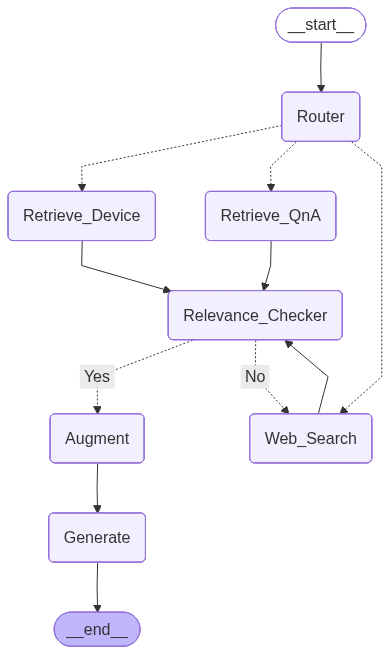

In [26]:
from IPython.display import Image, display
display(Image(agentic_rag.get_graph().draw_mermaid_png()))

# Test the Agentic RAG pipeline

In [27]:
input_state = {"query": "what is the treatment for down's symdrome"}

from pprint import pprint
for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running {key}:")
pprint(value["response"])

---ROUTER DECISION: Retrieve_QnA---
Retrieve_QnA
'Finished running Router:'
---RETRIEVING CONTEXT---
Question: What are the treatments for Antisynthetase syndrome ?. Answer: What treatment is available for antisynthetase syndrome? Corticosteroids are typically the first-line of treatment and may be required for several months or years. These medications are often given orally; however, in severe cases, intravenous methylprednisolone may be prescribe initially. Immunosuppressive medications may also be recommended, especially in people with severe muscle weakness or symptomatic interstitial lung disease. Physical therapy is often necessary to improve weakness, reduce further muscle wasting from disuse, and prevent muscle contractures.. Type: treatment. 
Question: What are the treatments for Orthostatic Hypotension ?. Answer: When orthostatic hypotension is caused by hypovolemia due to medications, the disorder may be reversed by adjusting the dosage or by discontinuing the medication. W

In [ ]:
input_state = {"query": "what was the company created the first vaccine for COVID-19"}

from pprint import pprint
for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running {key}:")
pprint(value["response"])